# Earthquake_standard
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue decomposition]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

In [3]:
from haversine import haversine

##### 1. Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [5]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]

##### 2. $f(x)$ 

In [6]:
f_true = _df.loc[:,"Magnitude"]

In [7]:
f = (f_true-f_true.mean())/f_true.std()

##### 3. Definition of Distiance at non-Euclidian space using Haversine Fomula

In [8]:
def dist(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

##### 4. Definition of a weighted adjacency matrix $W$

$$W_{u,v}=\begin{cases}{exp(-\frac{[dist(u,v)]^2}{2\theta^2})} & \quad \text{if } dist(u,v) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [9]:
def weight(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [10]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

##### 5. The weight edge function with temporal edge $(v_t,v_{t+1})$

$$W_{u_r,v_sj}=\begin{cases} {W_{u,v}} & \quad \text{ if }  u,v \in V_t  \\ W_{u,v} \odot \beta  & \quad \text{if }u=v \text{ and } r=s-1 \\ 0 & \quad \text{otherwise} \end{cases}$$

In [11]:
def beta(i,j,b):
    if _df.Year[i] == _df.Year[j]:
        return 1
    elif abs(int(_df.Year[i]) - int(_df.Year[j])) == 1:
        return b
    else:
        return 0

In [12]:
_beta = np.array([[beta(i,j,1) for i in  range(len(_df))] for j in range(len(_df))])

In [13]:
_W = W @ _beta

##### 6. Definition of Graph Laplacian matrix
- $L = D - W$

In [14]:
D = np.diag(_W.sum(axis=1))

In [15]:
L = D - _W

##### 7. Eigenvalue Decomposition
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [16]:
λ, Ψ = np.linalg.eig(L)

In [17]:
Λ = np.diag(λ)

##### 8. Singular Value Decomposition
- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, n$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [18]:
def p(i):
    return sum((f @ np.outer( Ψ[:,i], Ψ[:,i]))**2)

In [19]:
array_1 = np.array([p(i) for i in range(1,len(_df))])
varprop = array_1/array_1.sum()
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

##### 9. Principal components Analysis

In [20]:
_df["comp1"] = f @ np.outer( Ψ[:,0], Ψ[:,0])
_df["comp2"] = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])
_df["comp3"] = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])
_df["comp4"] = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])
_df["comp5"] = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])
_df["comp6"] = f @ np.outer( Ψ[:,_indexlst[4]], Ψ[:,_indexlst[4]])
_df["comp7"] = f @ np.outer( Ψ[:,_indexlst[5]], Ψ[:,_indexlst[5]])

##### **2004**, $n=571$

In [201]:
_G1 = nx.Graph(_W[:len(_df.query('Year<="2004"')),:len(_df.query('Year<="2004"'))]-np.identity(len(_df.query('Year=="2004"'))))
_pos1 = nx.spring_layout(_G1,iterations=20)
m_pos1 = list(zip(_df.query('Year=="2004"').Longitude,_df.query('Year=="2004"').Latitude))

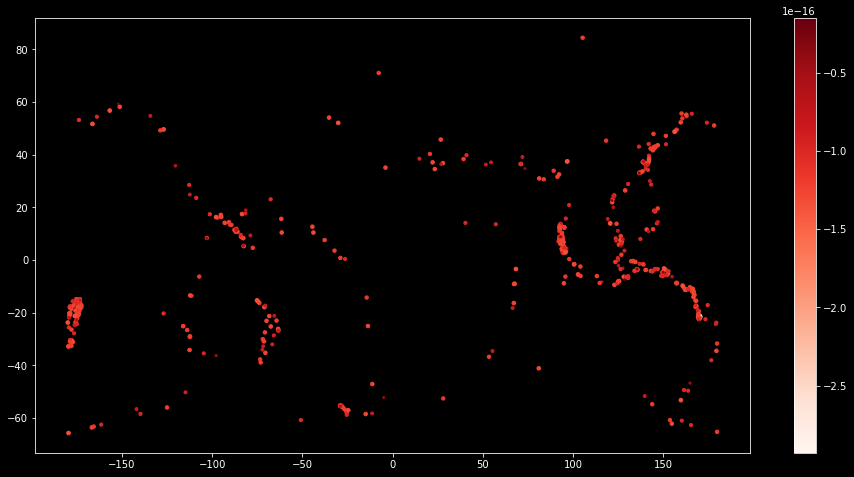

In [202]:
#collapse
with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp1,node_size = abs(_df.query('Year=="2004"').comp1)*100000000000000000, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

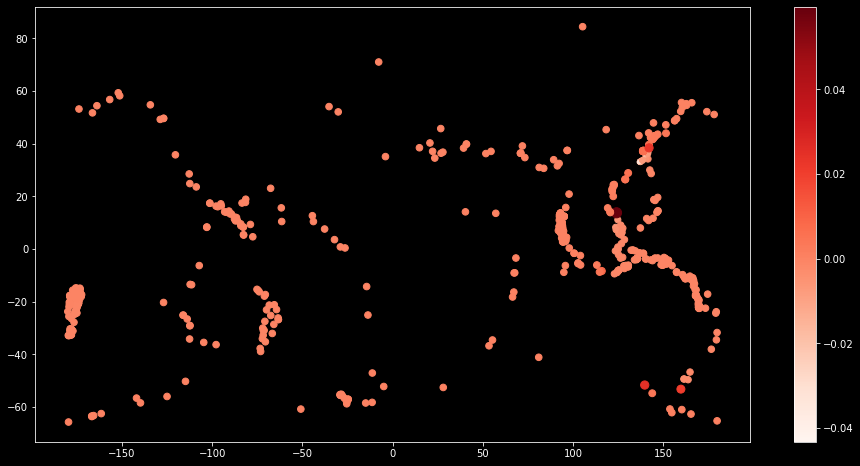

In [225]:
#collapse
_a = pd.DataFrame({'index':_df.query('Year=="2004"').index,'a':np.float32(_df.query('Year=="2004"').comp2 + np.abs(_df.query('Year=="2004"').sort_values('comp2').reset_index().iloc[0,7]))})

with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp2,node_size = _a.a*1000,ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

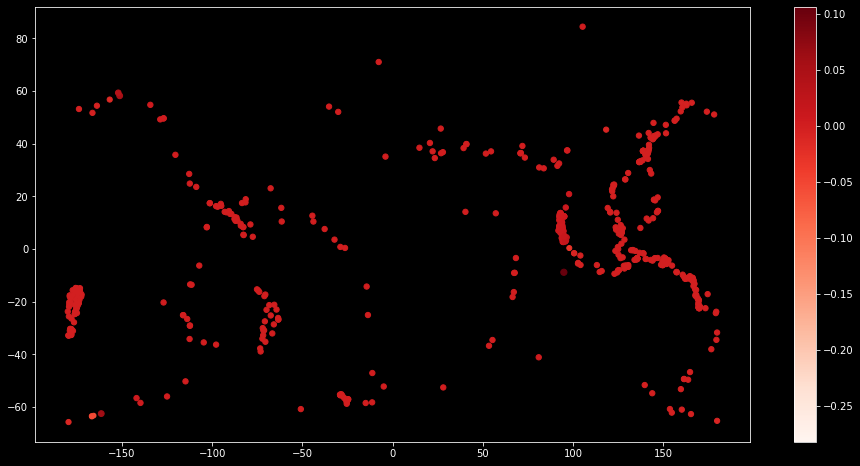

In [227]:
#collapse
_a = pd.DataFrame({'index':_df.query('Year=="2004"').index,'a':np.float32(_df.query('Year=="2004"').comp3 + np.abs(_df.query('Year=="2004"').sort_values('comp3').reset_index().iloc[0,8]))})

with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp3,node_size = _a.a*100, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

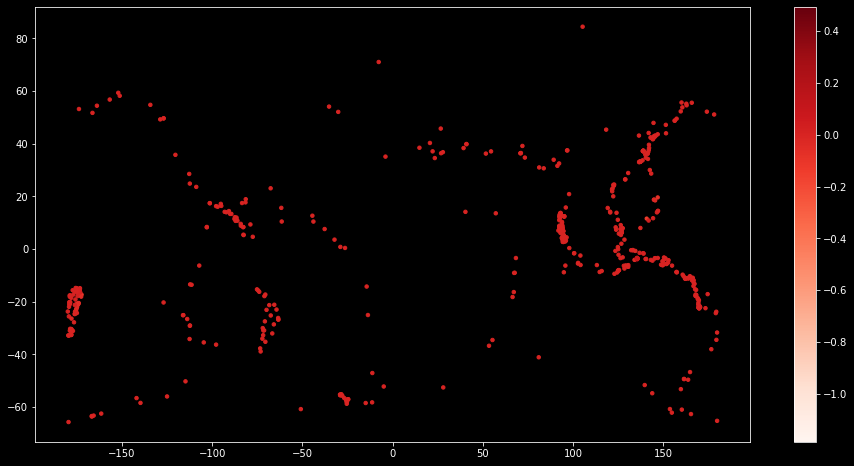

In [219]:
#collapse
_a = pd.DataFrame({'index':_df.query('Year=="2004"').index,'a':np.float32(_df.query('Year=="2004"').comp4 + np.abs(_df.query('Year=="2004"').sort_values('comp4').reset_index().iloc[0,9]))})

with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp4,node_size = _a.a*10, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

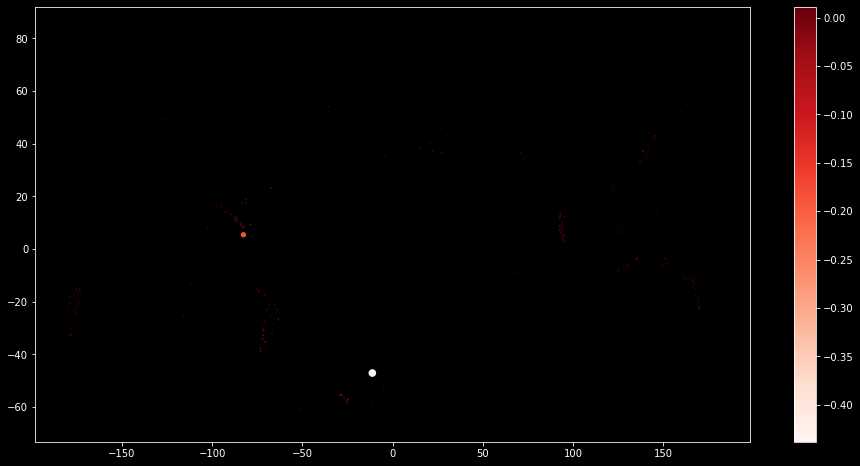

In [150]:
#collapse
with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp5,node_size = abs(_df.query('Year=="2004"').comp5)*100, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

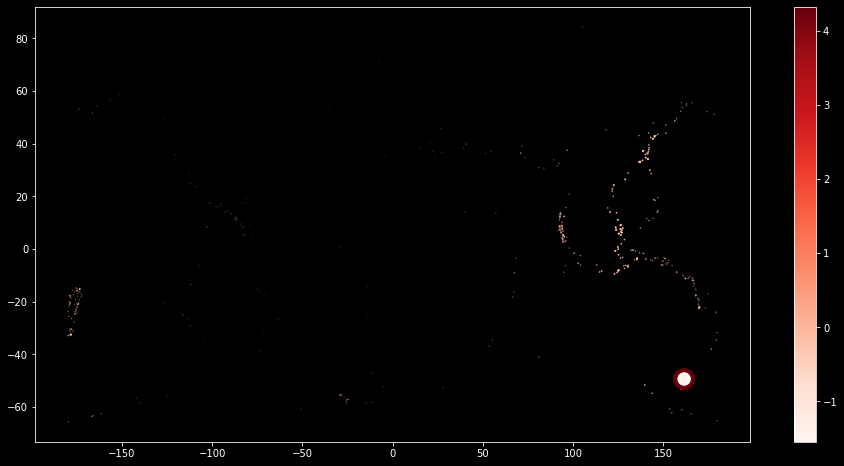

In [146]:
#collapse
with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp6,node_size = abs(_df.query('Year=="2004"').comp6)*100, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

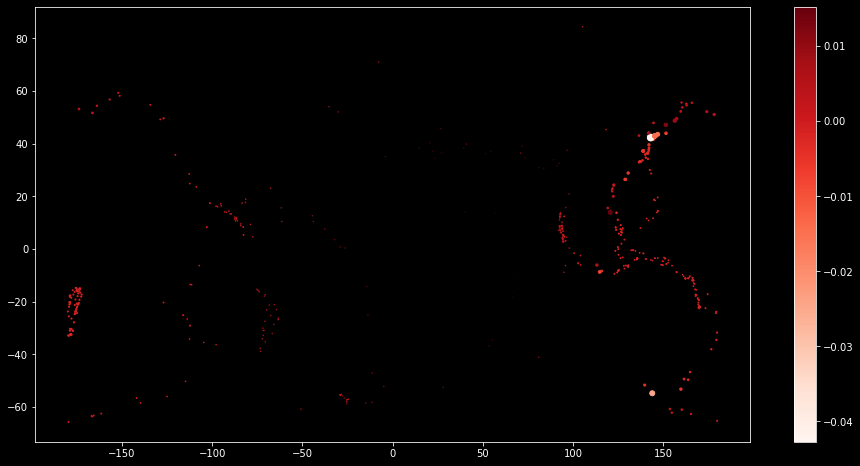

In [148]:
#collapse
with plt.style.context('dark_background'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp7,node_size = abs(_df.query('Year=="2004"').comp7)*1000, ax=ax,cmap='Reds')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2005**, $n=533$

In [29]:
_G2 = nx.Graph(_W[len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"')),len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"'))]-np.identity(len(_df.query('Year=="2005"'))))
_pos2 = nx.spring_layout(_G2,iterations=20)
m_pos2 = list(zip(_df.query('Year=="2005"').Longitude,_df.query('Year=="2005"').Latitude))

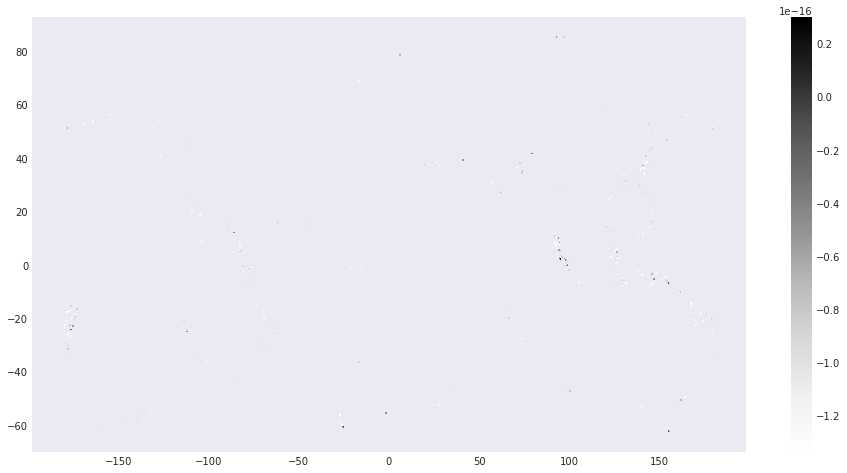

In [30]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp1,node_size = abs(_df.query('Year=="2005"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

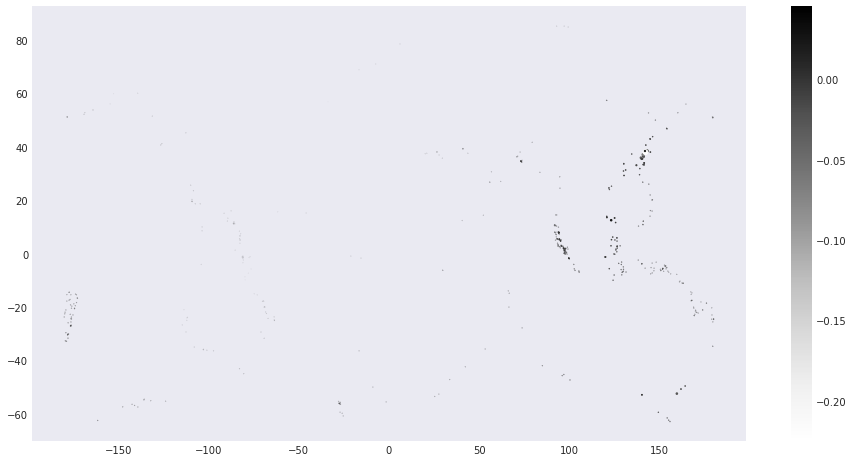

In [31]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp2,node_size = np.abs(_df.query('Year=="2005"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

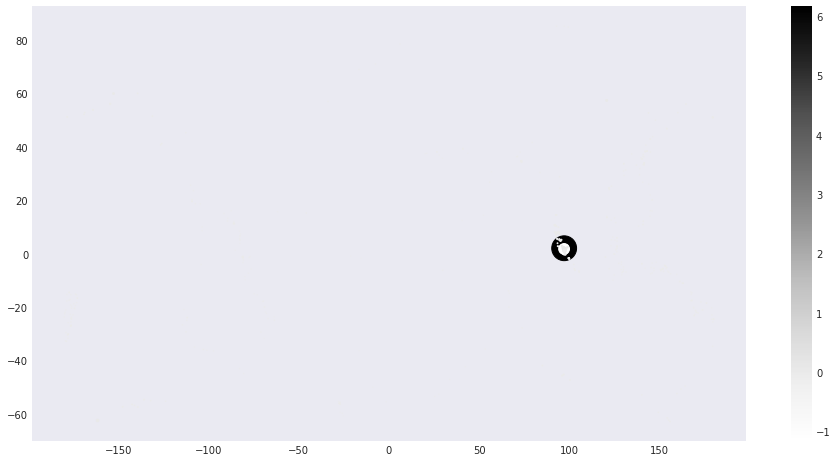

In [32]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp3,node_size = np.abs(_df.query('Year=="2005"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

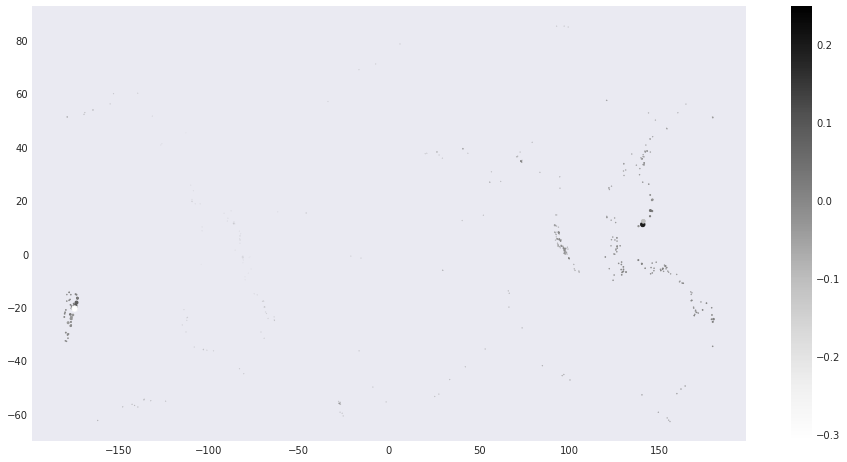

In [33]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp4,node_size = np.abs(_df.query('Year=="2005"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

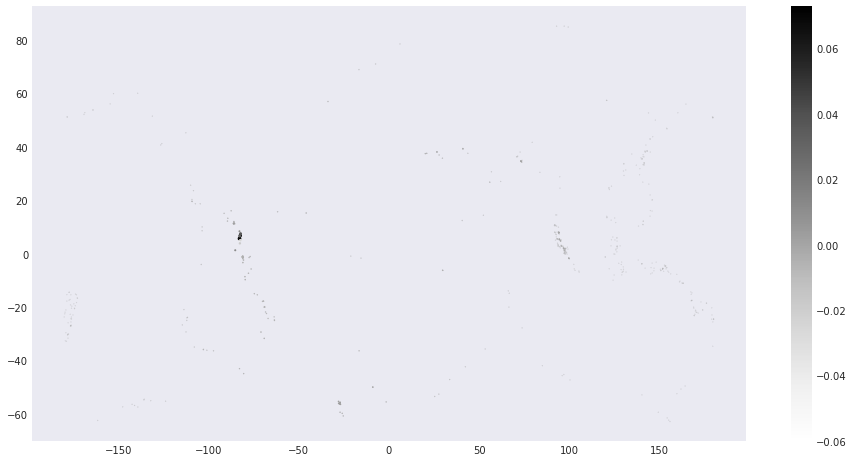

In [34]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp5,node_size = abs(_df.query('Year=="2005"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

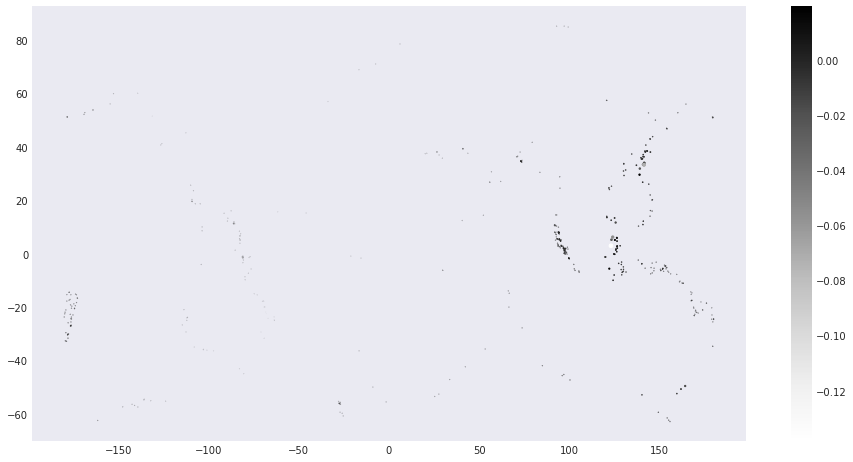

In [35]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp6,node_size = abs(_df.query('Year=="2005"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

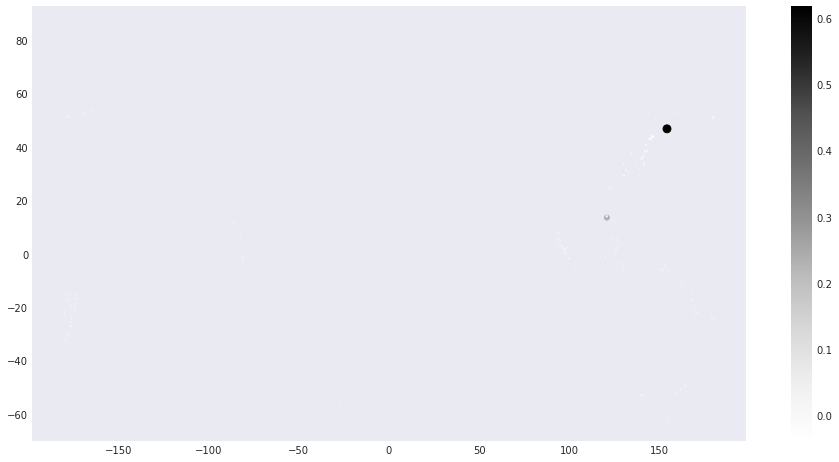

In [36]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp7,node_size = abs(_df.query('Year=="2005"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2006**, $n=512$

In [37]:
_G3 = nx.Graph(_W[len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"')),len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"'))]-np.identity(len(_df.query('Year=="2006"'))))
_pos3 = nx.spring_layout(_G3,iterations=20)
m_pos3 = list(zip(_df.query('Year=="2006"').Longitude,_df.query('Year=="2006"').Latitude))

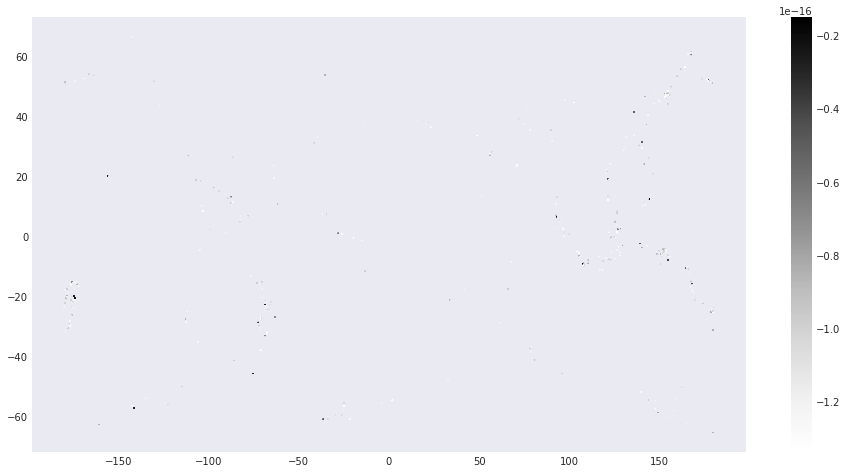

In [38]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp1,node_size = abs(_df.query('Year=="2006"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

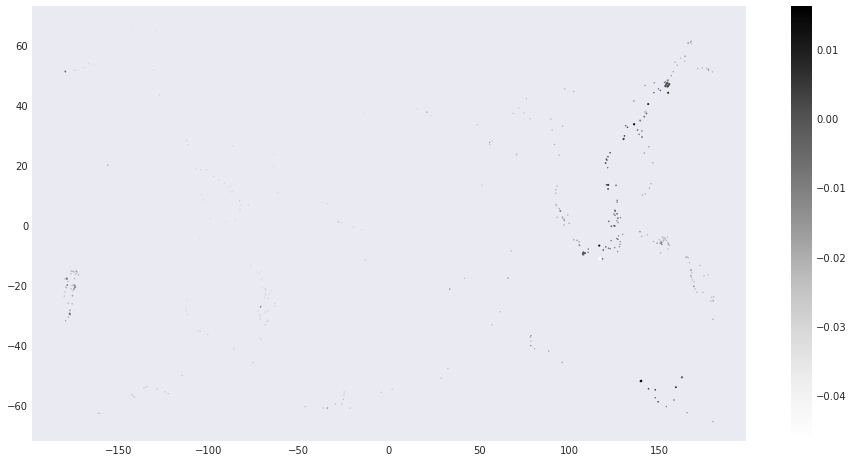

In [39]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp2,node_size = np.abs(_df.query('Year=="2006"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

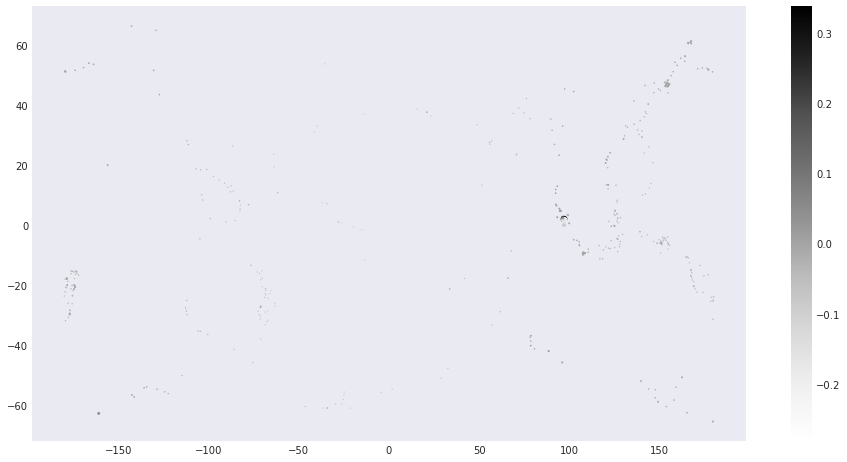

In [40]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp3,node_size = np.abs(_df.query('Year=="2006"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

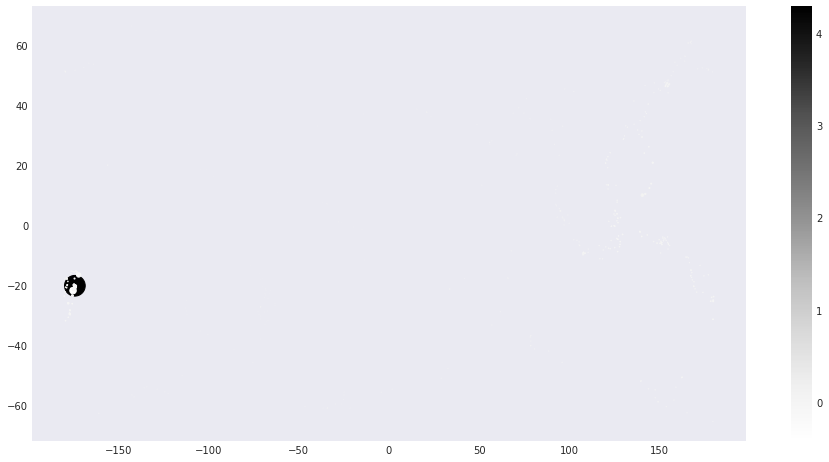

In [41]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp4,node_size = np.abs(_df.query('Year=="2006"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

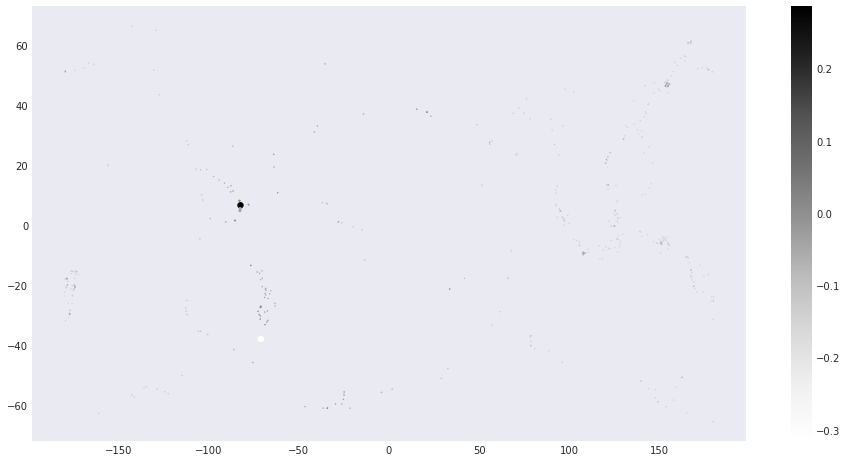

In [42]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp5,node_size = abs(_df.query('Year=="2006"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

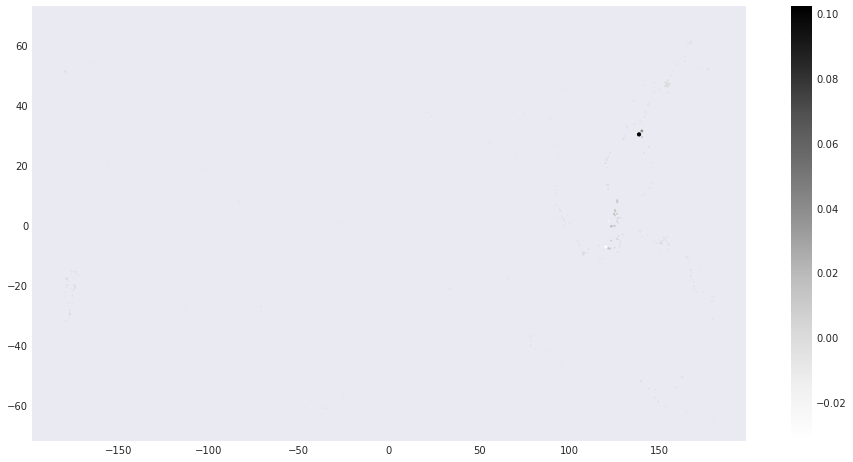

In [43]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp6,node_size = abs(_df.query('Year=="2006"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

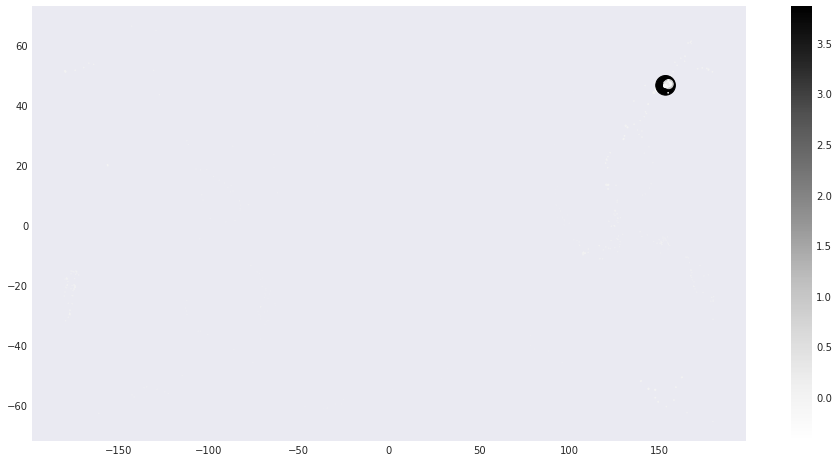

In [44]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp7,node_size = abs(_df.query('Year=="2006"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2007**, $n=608$

In [45]:
_G4 = nx.Graph(_W[len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"')),len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"'))]-np.identity(len(_df.query('Year=="2007"'))))
_pos4 = nx.spring_layout(_G4,iterations=20)
m_pos4 = list(zip(_df.query('Year=="2007"').Longitude,_df.query('Year=="2007"').Latitude))

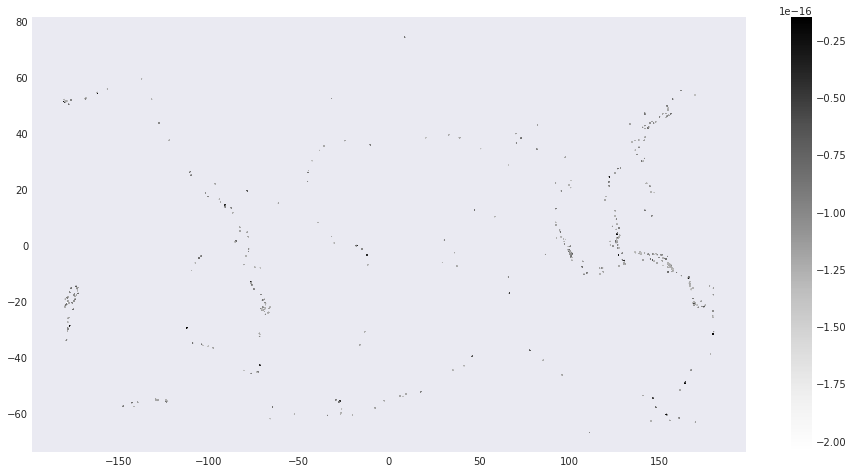

In [46]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp1,node_size = abs(_df.query('Year=="2007"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

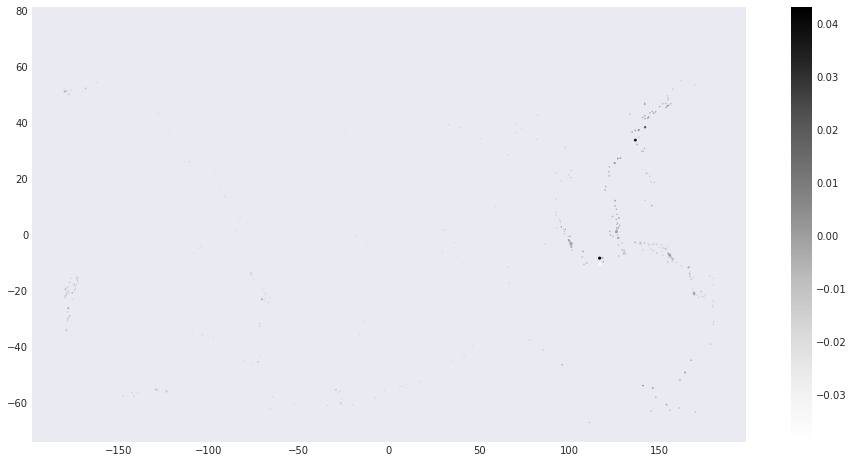

In [47]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp2,node_size = np.abs(_df.query('Year=="2007"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

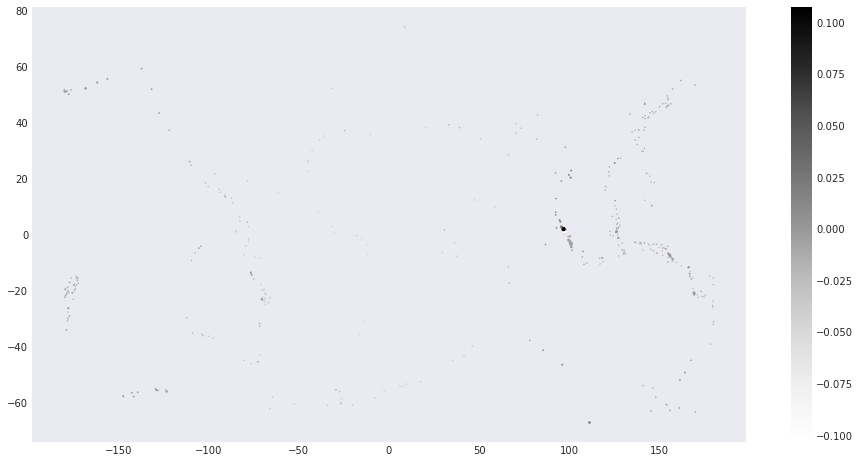

In [48]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp3,node_size = np.abs(_df.query('Year=="2007"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

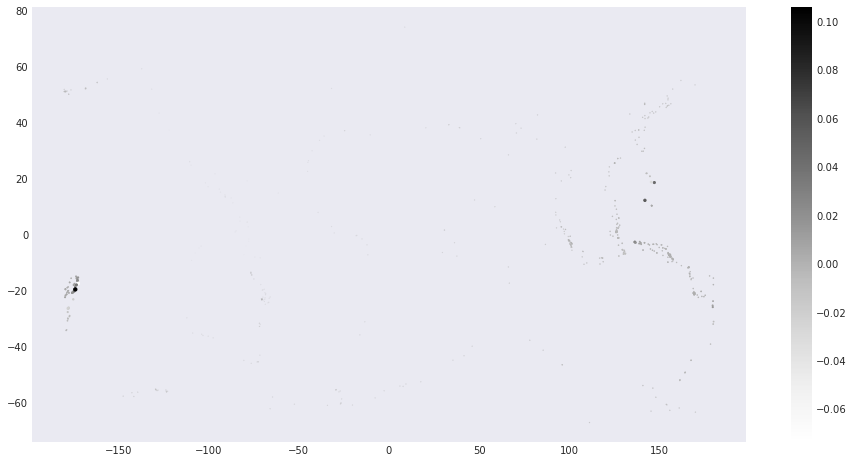

In [49]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp4,node_size = np.abs(_df.query('Year=="2007"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

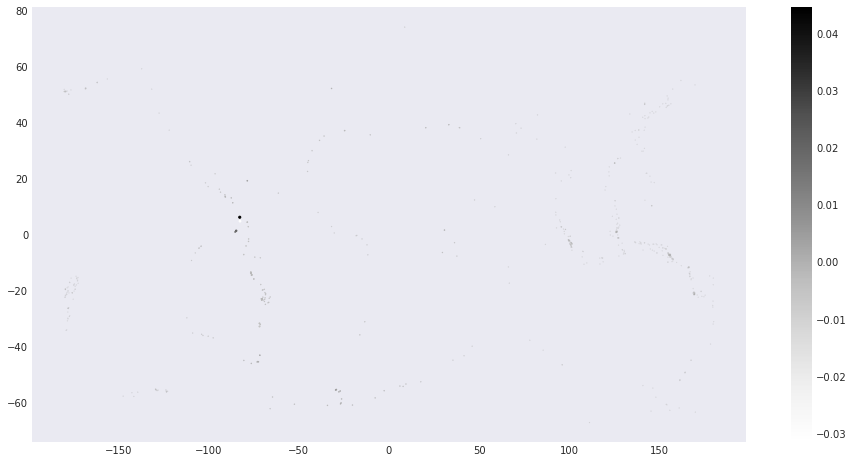

In [50]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp5,node_size = abs(_df.query('Year=="2007"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

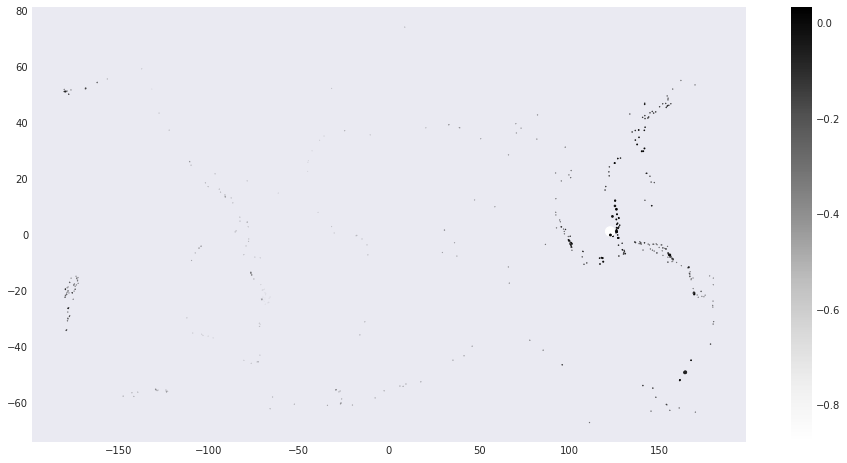

In [51]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp6,node_size = abs(_df.query('Year=="2007"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

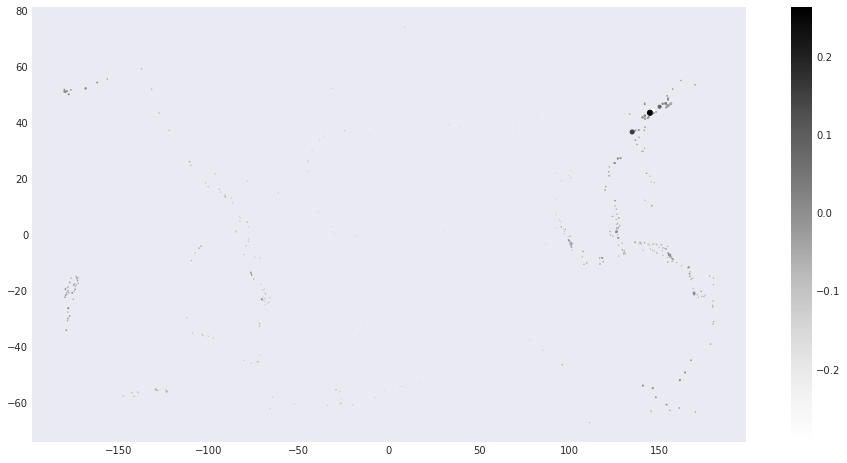

In [52]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp7,node_size = abs(_df.query('Year=="2007"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2008**, $n=508$

In [53]:
_G5 = nx.Graph(_W[len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"')),len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"'))]-np.identity(len(_df.query('Year=="2008"'))))
_pos5 = nx.spring_layout(_G5,iterations=20)
m_pos5 = list(zip(_df.query('Year=="2008"').Longitude,_df.query('Year=="2008"').Latitude))

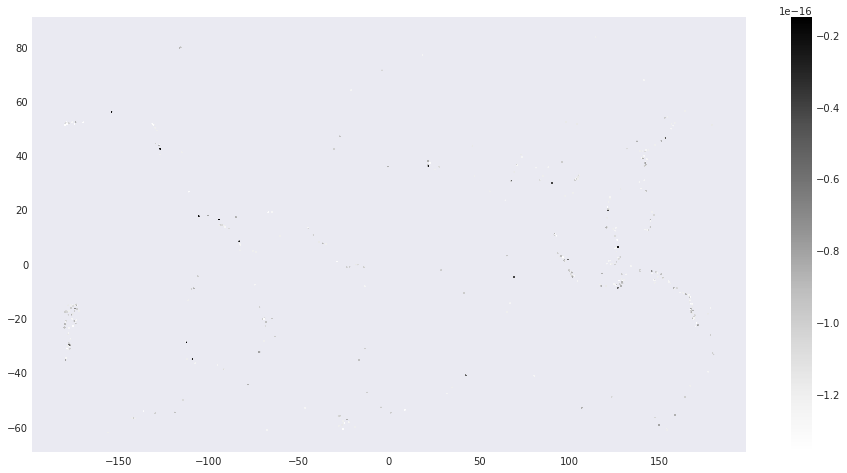

In [54]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp1,node_size = abs(_df.query('Year=="2008"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

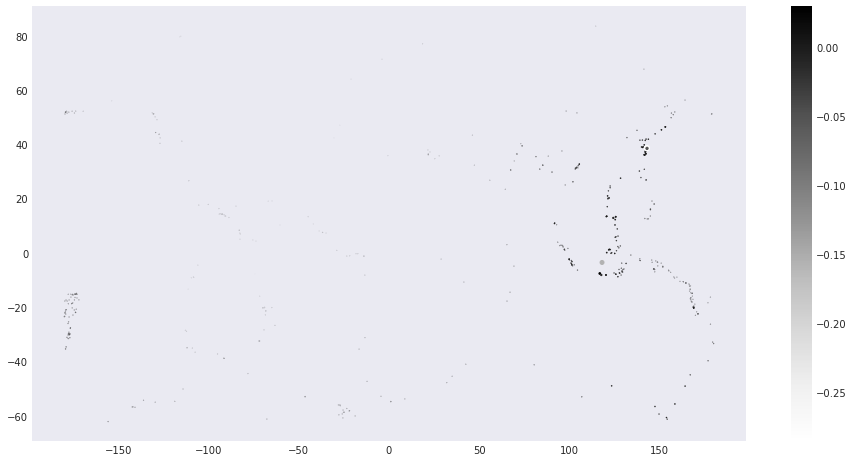

In [55]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp2,node_size = np.abs(_df.query('Year=="2008"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

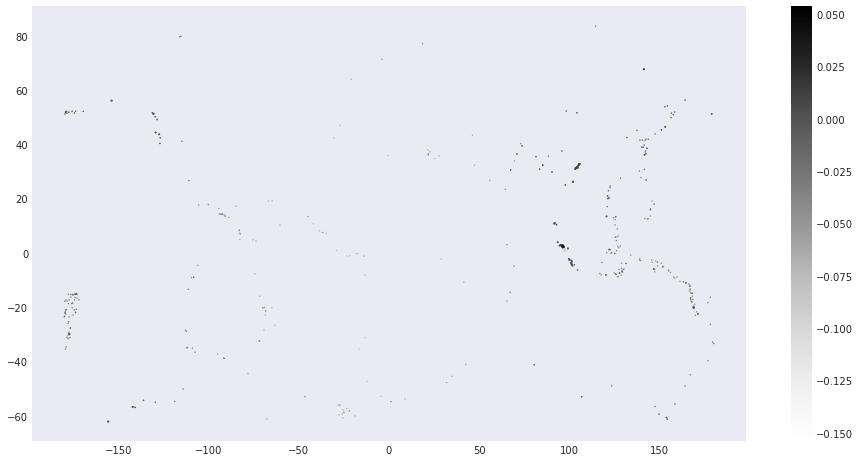

In [56]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp3,node_size = np.abs(_df.query('Year=="2008"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

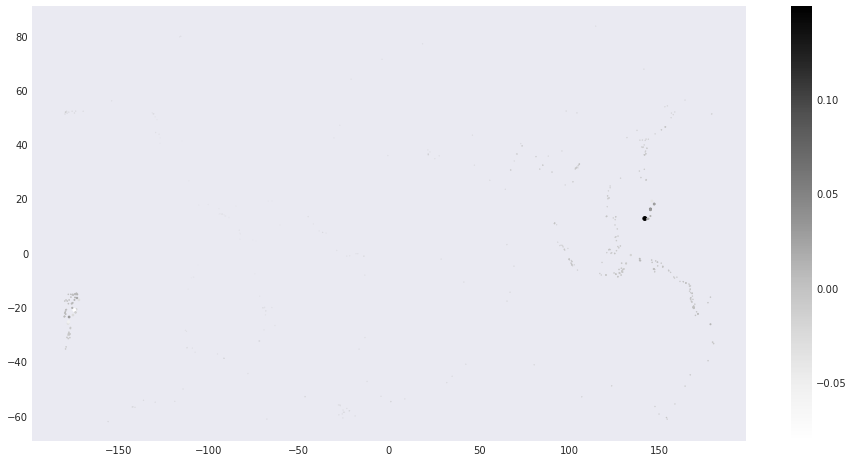

In [57]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp4,node_size = np.abs(_df.query('Year=="2008"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

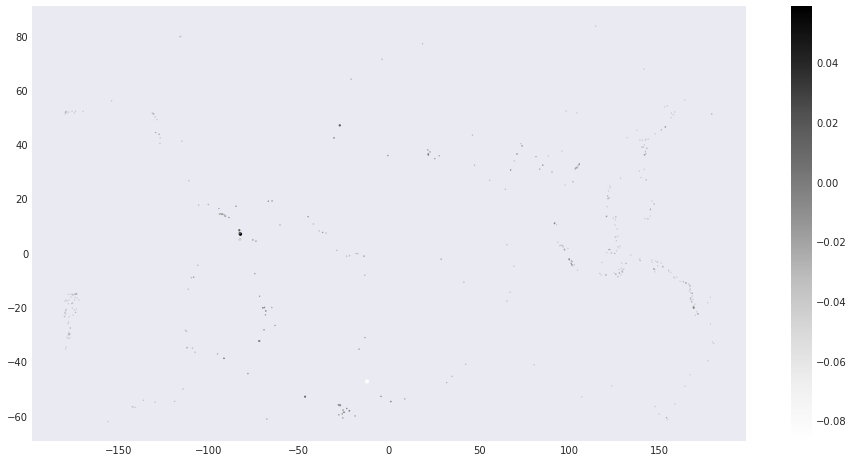

In [58]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp5,node_size = abs(_df.query('Year=="2008"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

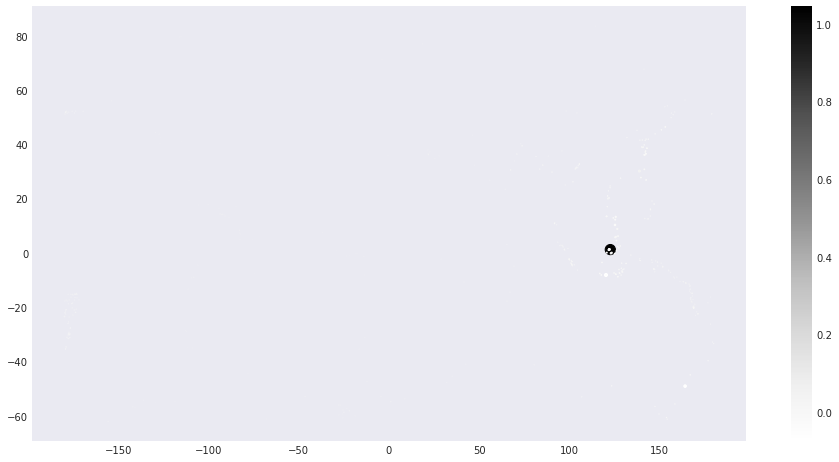

In [59]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp6,node_size = abs(_df.query('Year=="2008"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

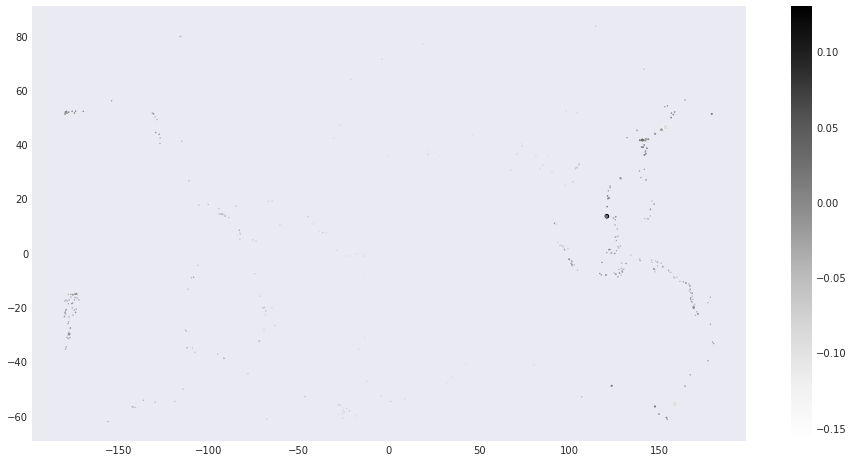

In [60]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp7,node_size = abs(_df.query('Year=="2008"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2009**, $n=517$

In [61]:
_G6 = nx.Graph(_W[len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"')),len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"'))]-np.identity(len(_df.query('Year=="2009"'))))
_pos6 = nx.spring_layout(_G6,iterations=20)
m_pos6 = list(zip(_df.query('Year=="2009"').Longitude,_df.query('Year=="2009"').Latitude))

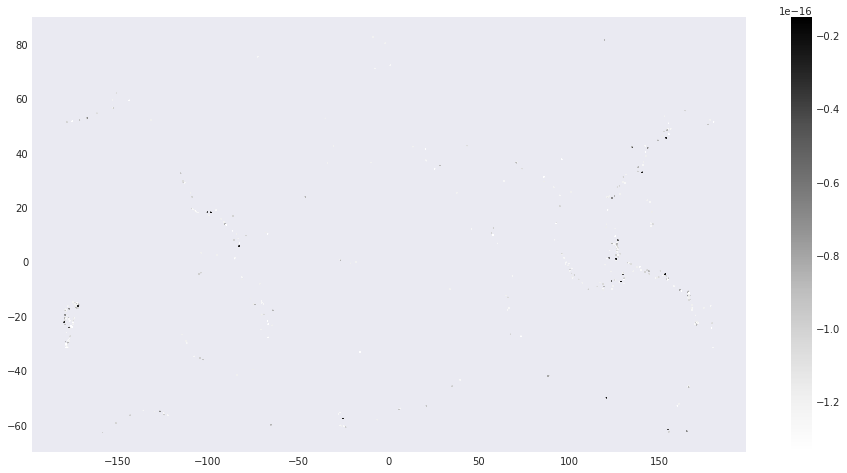

In [62]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp1,node_size = abs(_df.query('Year=="2009"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

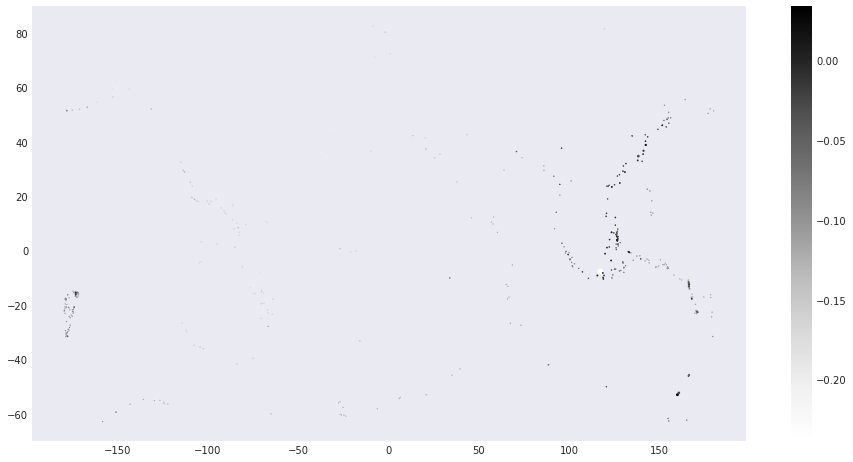

In [63]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp2,node_size = np.abs(_df.query('Year=="2009"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

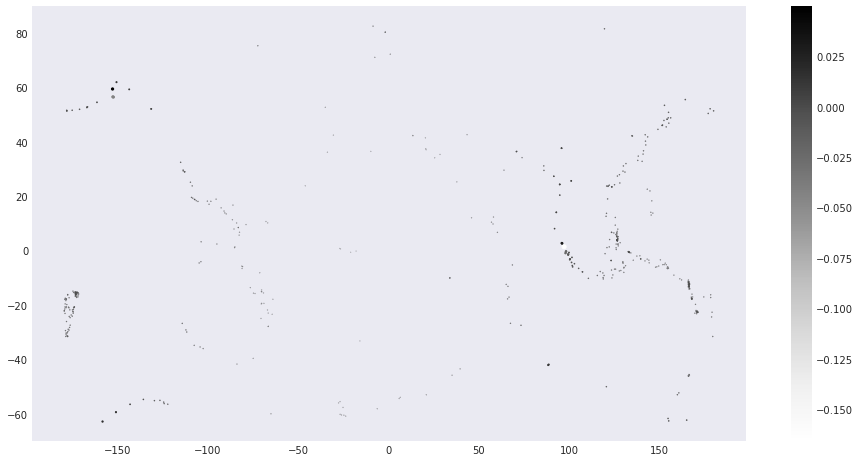

In [64]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp3,node_size = np.abs(_df.query('Year=="2009"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

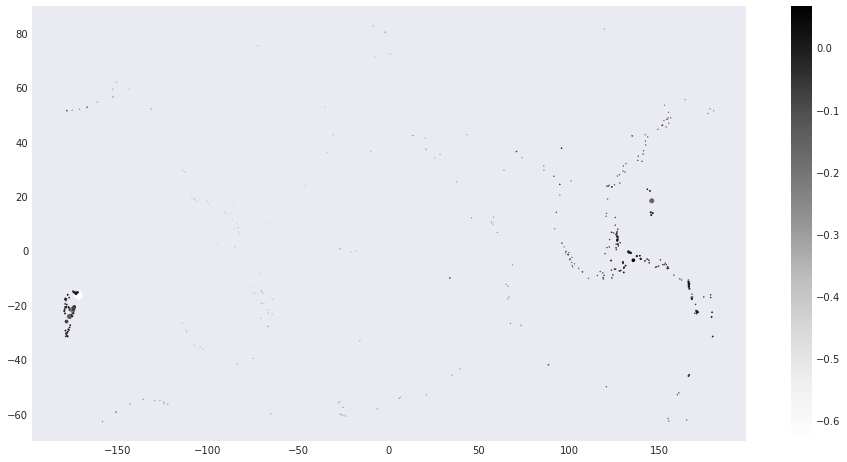

In [65]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp4,node_size = np.abs(_df.query('Year=="2009"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

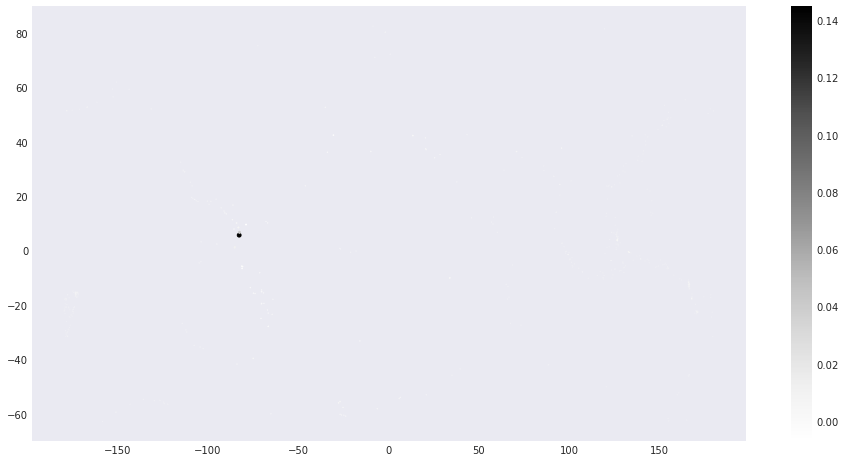

In [66]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp5,node_size = abs(_df.query('Year=="2009"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

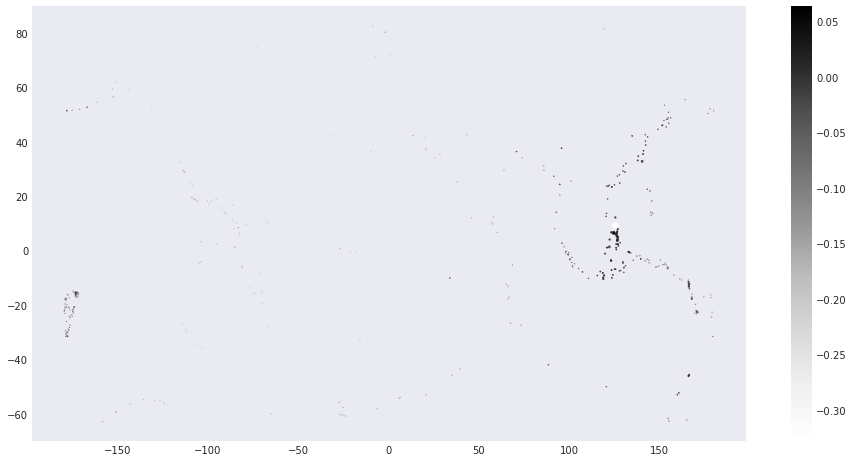

In [67]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp6,node_size = abs(_df.query('Year=="2009"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

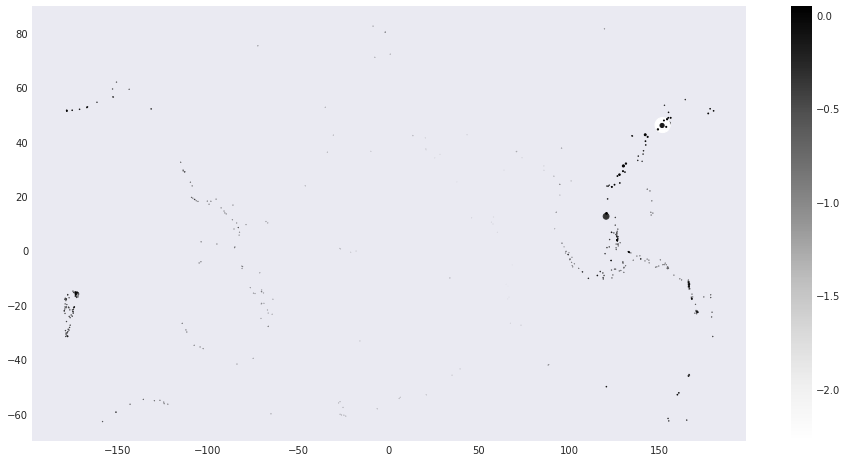

In [68]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp7,node_size = abs(_df.query('Year=="2009"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2010**, $n=560$

In [69]:
_G7 = nx.Graph(_W[len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"')),len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"'))]-np.identity(len(_df.query('Year=="2010"'))))
_pos7 = nx.spring_layout(_G7,iterations=20)
m_pos7 = list(zip(_df.query('Year=="2010"').Longitude,_df.query('Year=="2010"').Latitude))

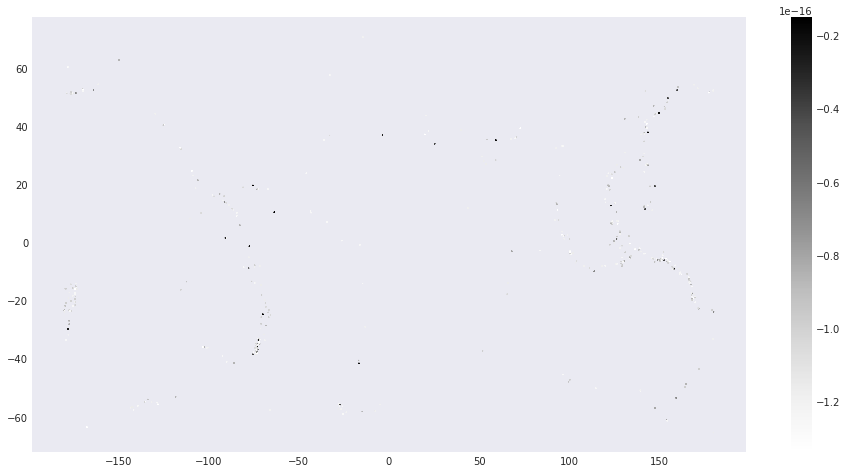

In [70]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp1,node_size = abs(_df.query('Year=="2010"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

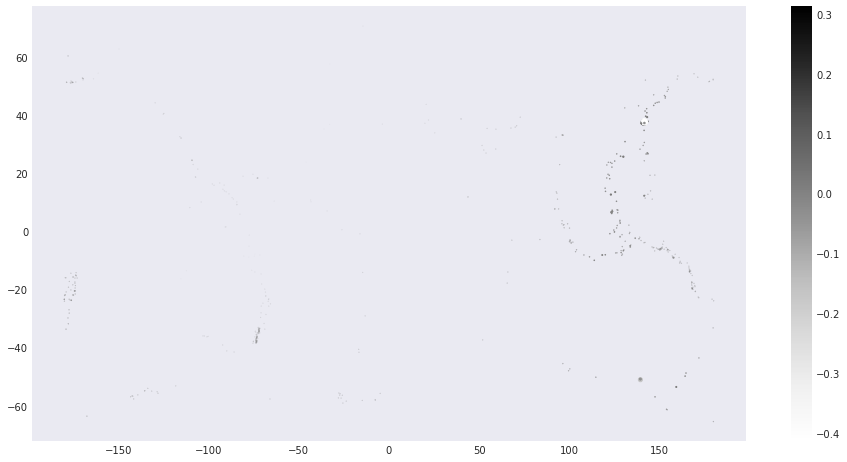

In [71]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp2,node_size = np.abs(_df.query('Year=="2010"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

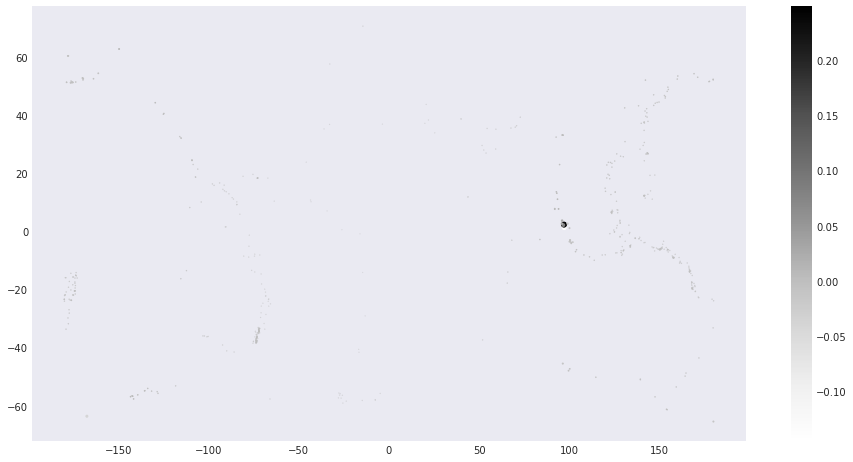

In [72]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp3,node_size = np.abs(_df.query('Year=="2010"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

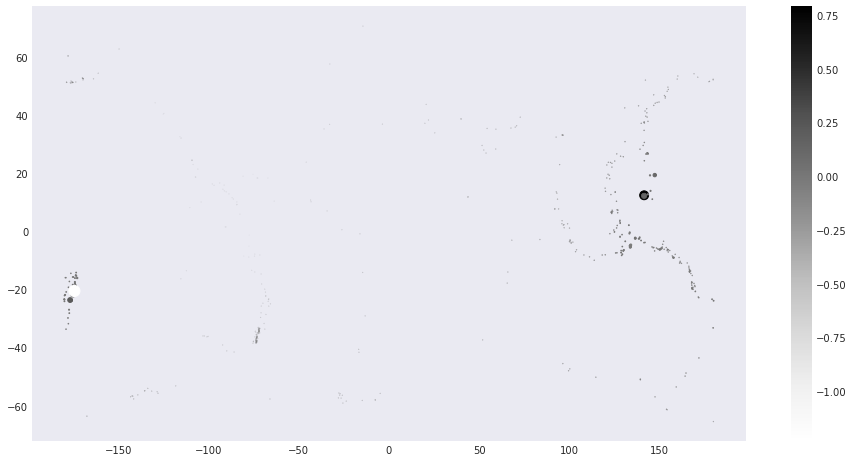

In [73]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp4,node_size = np.abs(_df.query('Year=="2010"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

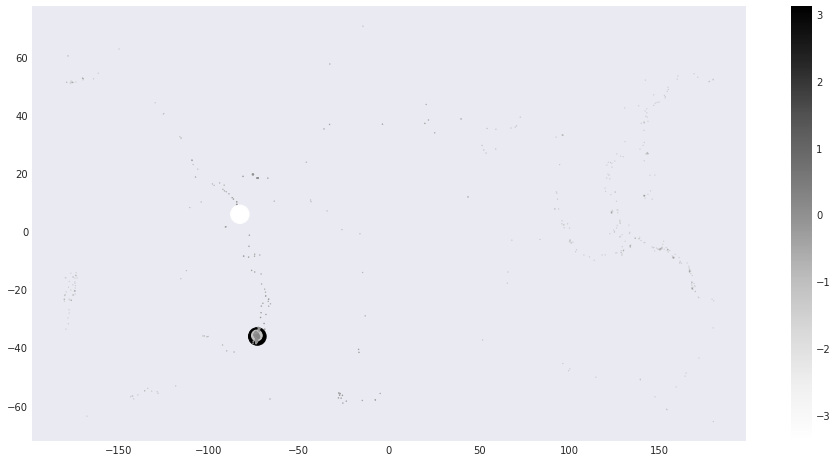

In [74]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp5,node_size = abs(_df.query('Year=="2010"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

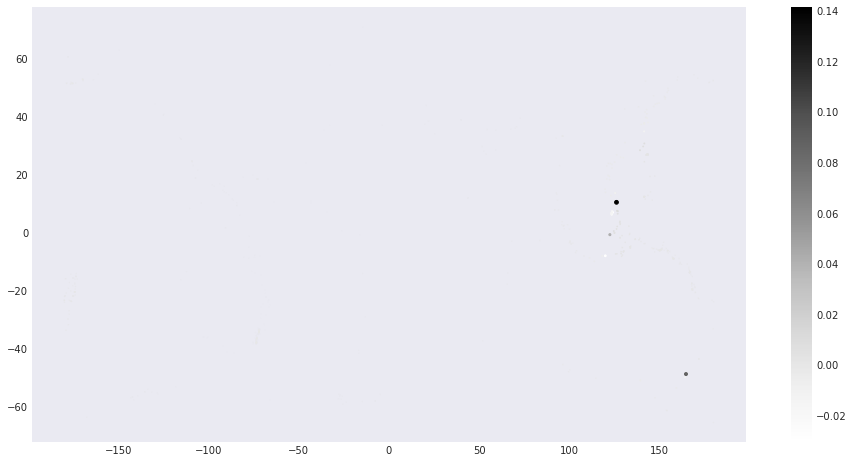

In [75]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp6,node_size = abs(_df.query('Year=="2010"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

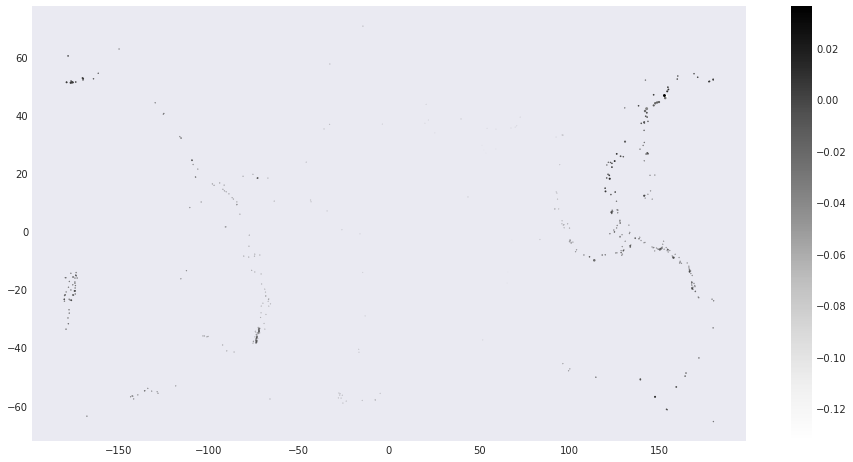

In [76]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp7,node_size = abs(_df.query('Year=="2010"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2011**, $n=712$

In [77]:
_G8 = nx.Graph(_W[len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"')),len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"'))]-np.identity(len(_df.query('Year=="2011"'))))
_pos8 = nx.spring_layout(_G8,iterations=20)
m_pos8 = list(zip(_df.query('Year=="2011"').Longitude,_df.query('Year=="2011"').Latitude))

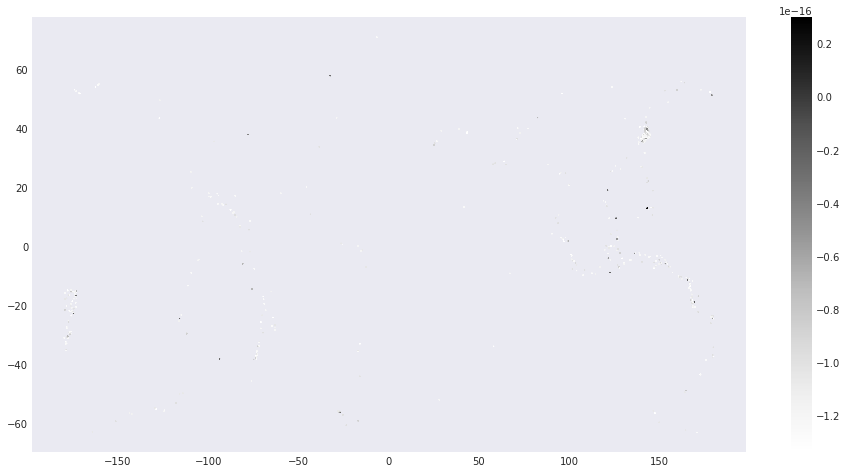

In [78]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp1,node_size = abs(_df.query('Year=="2011"').comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

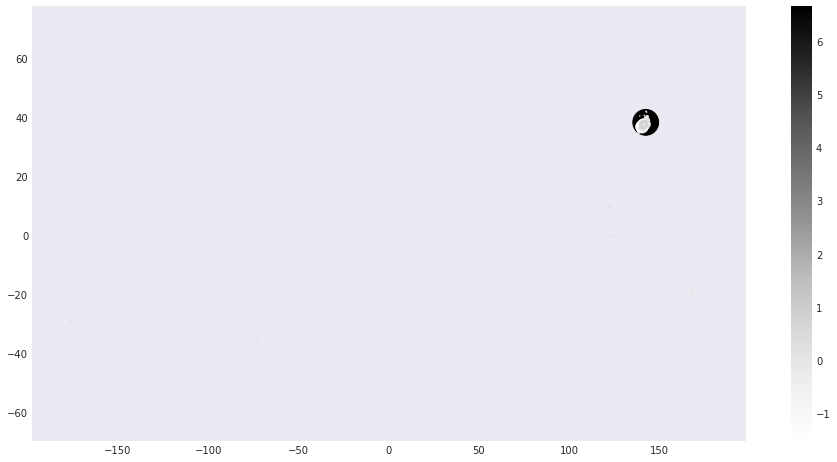

In [79]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp2,node_size = np.abs(_df.query('Year=="2011"').comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

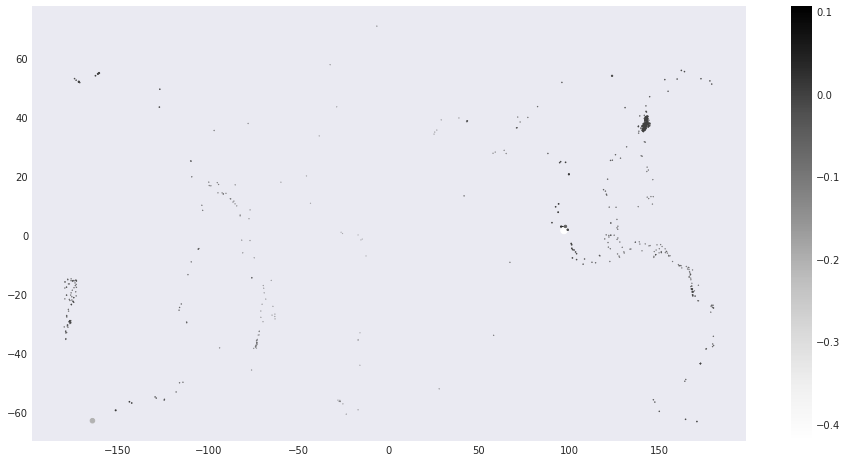

In [80]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp3,node_size = np.abs(_df.query('Year=="2011"').comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

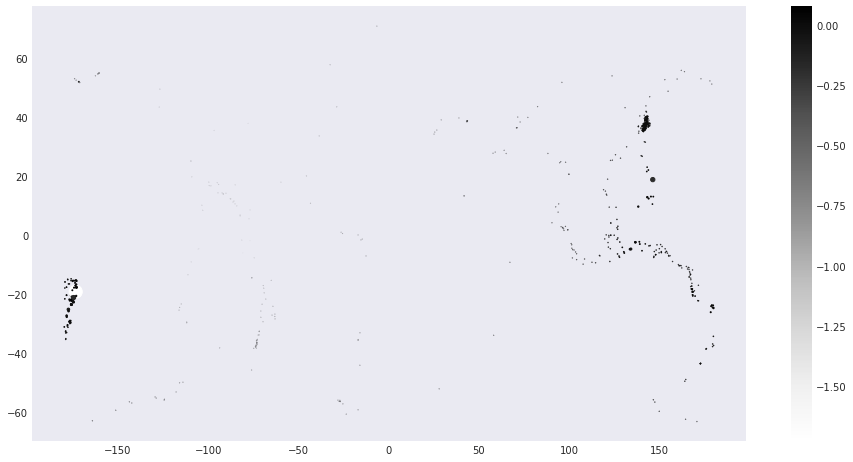

In [81]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp4,node_size = np.abs(_df.query('Year=="2011"').comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

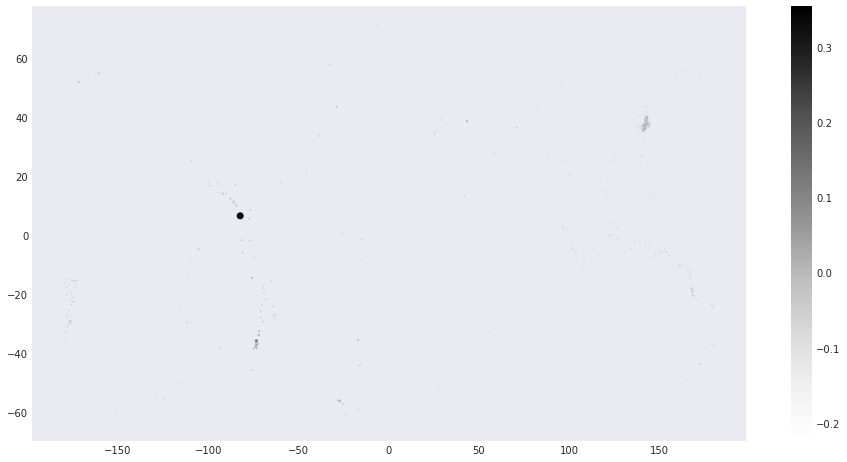

In [82]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp5,node_size = abs(_df.query('Year=="2011"').comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

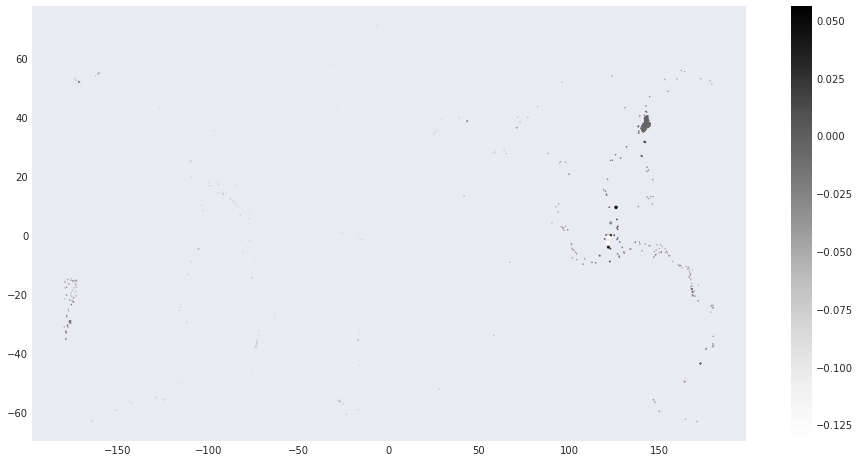

In [83]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp6,node_size = abs(_df.query('Year=="2011"').comp6)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

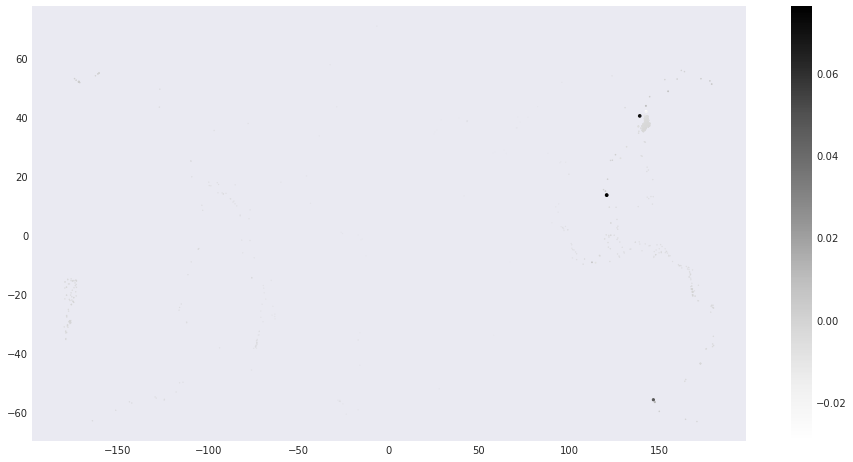

In [84]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp7,node_size = abs(_df.query('Year=="2011"').comp7)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()